#GAN + RNN, LSTM, GRU as discriminator

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

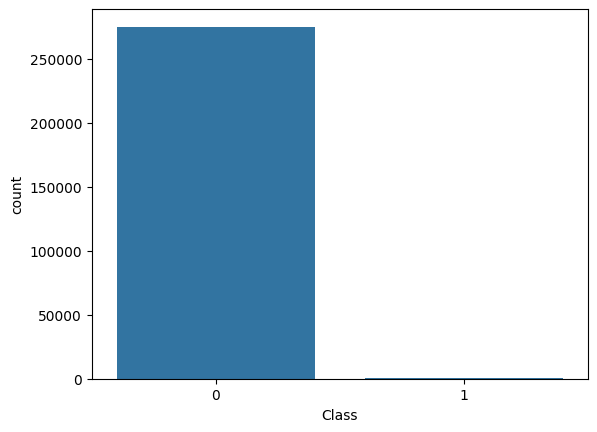

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


<Axes: xlabel='Amount', ylabel='Density'>

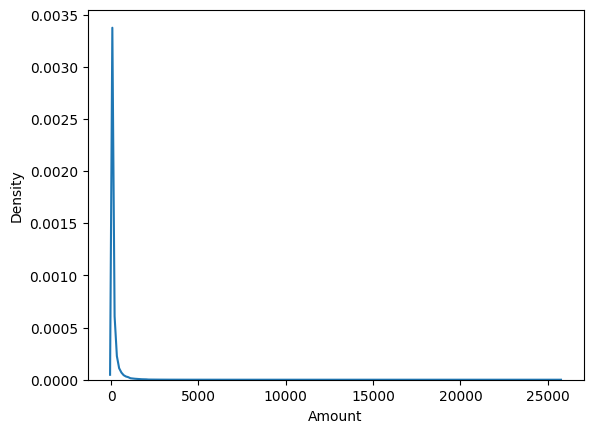

In [ ]:
sns.kdeplot(df['Amount'])

<Axes: xlabel='Amount', ylabel='Density'>

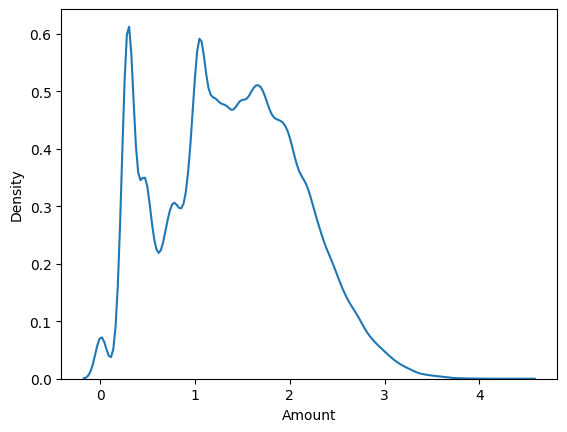

In [ ]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [ ]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [ ]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

Note-Used chatgpt to understand the correlations. As the features are anonymised it was difficult to conclude and get relationship and dependency on eachother.

In [ ]:
# Calculate absolute correlation matrix (optional: choose df or new_df)
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates and self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold
threshold = 0.9

# Find feature pairs with high correlation
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.columns
                   if (upper.loc[col1, col2] > threshold)]

# Display results
print("Highly Correlated Feature Pairs (|r| > 0.9):")
for f1, f2, corr_value in high_corr_pairs:
    print(f"{f1} ↔ {f2}: r = {corr_value:.2f}")

Highly Correlated Feature Pairs (|r| > 0.9):
V11 ↔ V12: r = 0.90
V12 ↔ V16: r = 0.90
V16 ↔ V17: r = 0.96
V16 ↔ V18: r = 0.91
V17 ↔ V18: r = 0.94


Reference-https://data36.com/correlation-definition-calculation-corr-pandas/

### TSNE

In [ ]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [ ]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

Reference- https://www.geeksforgeeks.org/machine-learning/difference-between-pca-vs-t-sne/

Note-ChatGPT was used to help understand the results using WebSearch Feature.

## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## GAN Architecture

In [ ]:
# For RNN‑based discriminators we treat each feature vector as a sequence of length = n_features
seq_len = X_train.shape[1]
def to_sequence(X):
    return X.reshape(-1, seq_len, 1)

# ------------------------------------------------------------
# 2. Define the generator (fully connected):contentReference[oaicite:5]{index=5}
# ------------------------------------------------------------
def build_generator(latent_dim, output_dim):
    model = models.Sequential(name='generator')
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(output_dim, activation='tanh'))
    return model



In [ ]:
# ------------------------------------------------------------
# 3. Define discriminators using RNN, LSTM and GRU:contentReference[oaicite:6]{index=6}
# ------------------------------------------------------------
def build_rnn_discriminator(seq_len):
    model = models.Sequential(name='rnn_discriminator')
    model.add(layers.SimpleRNN(64, input_shape=(seq_len,1)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def build_lstm_discriminator(seq_len):
    model = models.Sequential(name='lstm_discriminator')
    model.add(layers.LSTM(64, input_shape=(seq_len,1)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def build_gru_discriminator(seq_len):
    model = models.Sequential(name='gru_discriminator')
    model.add(layers.GRU(64, input_shape=(seq_len,1)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model



In [ ]:
# ------------------------------------------------------------
# 4. Training function for GAN with a chosen discriminator
# ------------------------------------------------------------
class GAN_RNN:
    def __init__(self, discriminator_builder, latent_dim=32, lr=1e-4):
        self.latent_dim = latent_dim
        self.output_dim = seq_len     # number of features

        self.generator = build_generator(latent_dim, self.output_dim)
        self.discriminator = discriminator_builder(seq_len)
        self.d_optimizer = optimizers.Adam(lr)
        self.g_optimizer = optimizers.Adam(lr)
        self.bce = tf.keras.losses.BinaryCrossentropy()

    @tf.function
    def train_step(self, real_samples):
        batch_size = tf.shape(real_samples)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            # generate fake samples
            generated = self.generator(noise, training=True)
            generated_seq = tf.reshape(generated, (-1, seq_len, 1))
            real_seq = tf.reshape(real_samples, (-1, seq_len, 1))
            # discriminator output
            real_output = self.discriminator(real_seq, training=True)
            fake_output = self.discriminator(generated_seq, training=True)

            d_loss = self.bce(tf.ones_like(real_output), real_output) + \
                     self.bce(tf.zeros_like(fake_output), fake_output)
            g_loss = self.bce(tf.ones_like(fake_output), fake_output)
        # update discriminator
        d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        # update generator
        g_grads = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        return d_loss, g_loss

    def train(self, X, epochs=100, batch_size=256):
        dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(buffer_size=1024).batch(batch_size)
        for epoch in range(epochs):
            for real_batch in dataset:
                self.train_step(real_batch)

    def generate(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim])
        gen_samples = self.generator.predict(noise)
        return gen_samples



In [ ]:
# ------------------------------------------------------------
# 5. Train and fine‑tune each GAN variant
# ------------------------------------------------------------
# Prepare only-fraud samples for training the generator/discriminator
fraud_samples = X_train[y_train == 1]
# RNN discriminator
gan_rnn = GAN_RNN(build_rnn_discriminator)
gan_rnn.train(fraud_samples, epochs=200, batch_size=128)





/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# LSTM discriminator
gan_lstm = GAN_RNN(build_lstm_discriminator)
gan_lstm.train(fraud_samples, epochs=200, batch_size=128)


In [ ]:
# GRU discriminator
gan_gru = GAN_RNN(build_gru_discriminator)
gan_gru.train(fraud_samples, epochs=200, batch_size=128)

In [ ]:
# after adversarial training, fine‑tune the discriminator to classify fraud vs legit
def fine_tune_discriminator(discriminator, X_train, y_train):
    discriminator.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(1e-4),
        metrics=['accuracy']
    )
    X_seq = to_sequence(X_train)
    discriminator.fit(X_seq, y_train, epochs=10, batch_size=256, validation_split=0.1)

fine_tune_discriminator(gan_rnn.discriminator, X_train, y_train)
fine_tune_discriminator(gan_lstm.discriminator, X_train, y_train)
fine_tune_discriminator(gan_gru.discriminator, X_train, y_train)


from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

def evaluate_discriminator(discriminator, X_test, y_test):
    preds = discriminator.predict(to_sequence(X_test))
    y_prob = preds.flatten() # flatten predictions for roc_auc_score and average_precision_score
    y_pred = (y_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_test, y_prob)
    pr  = average_precision_score(y_test, y_prob)

    print(f"\nROC-AUC: {roc:.4f}")
    print(f"PR-AUC:  {pr:.4f}\n")

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



776/776 ━━━━━━━━━━━━━━━━━━━━ 126s 162ms/step - accuracy: 0.9911 - loss: 0.0385 - val_accuracy: 0.9987 - val_loss: 0.0047
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 142s 162ms/step - accuracy: 0.9988 - loss: 0.0055 - val_accuracy: 0.9994 - val_loss: 0.0036
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 142s 163ms/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.9994 - val_loss: 0.0034
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 146s 169ms/step - accuracy: 0.9992 - loss: 0.0048 - val_accuracy: 0.9997 - val_loss: 0.0027
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 138s 163ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9996 - val_loss: 0.0026
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 140s 161ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 0.9996 - val_loss: 0.0025
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 146s 167ms/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.9996 - val_loss: 0.0025
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 139s 164ms/step - accuracy: 0.9994 - loss: 0.00

In [ ]:
print("GAN‑RNN performance:")
evaluate_discriminator(gan_rnn.discriminator, X_test, y_test)


GAN‑RNN performance:
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 114s 66ms/step

ROC-AUC: 0.9514
PR-AUC:  0.8142

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.88      0.79      0.83        95

    accuracy                           1.00     55133
   macro avg       0.94      0.89      0.92     55133
weighted avg       1.00      1.00      1.00     55133

[[55028    10]
 [   20    75]]


In [ ]:
print("GAN‑LSTM performance:")
evaluate_discriminator(gan_lstm.discriminator, X_test, y_test)


GAN‑LSTM performance:
   1/1723 ━━━━━━━━━━━━━━━━━━━━ 3:18 115ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1723/1723 ━━━━━━━━━━━━━━━━━━━━ 169s 98ms/step

ROC-AUC: 0.9456
PR-AUC:  0.7898

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.87      0.81      0.84        95

    accuracy                           1.00     55133
   macro avg       0.93      0.91      0.92     55133
weighted avg       1.00      1.00      1.00     55133

[[55026    12]
 [   18    77]]


In [ ]:
print("GAN‑GRU performance:")
evaluate_discriminator(gan_gru.discriminator, X_test, y_test)

GAN‑GRU performance:


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1723/1723 ━━━━━━━━━━━━━━━━━━━━ 259s 151ms/step

ROC-AUC: 0.9188
PR-AUC:  0.7339

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.86      0.74      0.80        95

    accuracy                           1.00     55133
   macro avg       0.93      0.87      0.90     55133
weighted avg       1.00      1.00      1.00     55133

[[55027    11]
 [   25    70]]


Interpretation

Overall accuracy is perfect (~100%) because of the extreme imbalance, so ROC-AUC and PR-AUC are more meaningful.

GAN-RNN achieved the highest PR-AUC (0.8142), meaning it balances false positives and recall best for anomaly detection.

GAN-LSTM had slightly lower PR-AUC (0.7898) but achieved the highest recall (81%) and the best F1 (0.84) among the three.

GAN-GRU lagged behind, with weaker recall (74%) and the lowest PR-AUC (0.7339).

Conclusion
GAN-RNN and GAN-LSTM are both strong contenders:

Choose GAN-RNN if you prioritize overall anomaly ranking ability (higher PR-AUC).

Choose GAN-LSTM if you prioritize recall (catching more anomalies, fewer misses).

GAN-GRU underperforms here and is less suitable compared to RNN/LSTM variants.

Note-ChatGPT was used to help understand the results of all 3 discriminator and also for code solving code errors while combining the real and synthetic

References- [A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186)